<a href="https://colab.research.google.com/github/R3gm/SD_diffusers_interactive/blob/main/Stable_diffusion_interactive_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interactive Stable Diffusion 0.5.0

| Description | Link |
| ----------- | ---- |
| 🎉 Repository | [![GitHub Repository](https://img.shields.io/github/stars/R3gm/SD_diffusers_interactive?style=social)](https://github.com/R3gm/SD_diffusers_interactive) |


- Latent upscaler
- Perturbed Attention Guidance (PAG).
- ControlNet union for SDXL
- Gallery explorer and PNG Info
- Support SDXL models from civitai (safetensors).
- IP Adapter with the variants FaceID and Instant-Style.
- ControlNet optical pattern, tile, recolor for SD1.5 and SDXL
- New prompt weight options.
- Fixed download issues (You need `CIVITAI_API_KEY` to download from Civitai).
- Style prompts.
- Img2img, inpaint, tile realistic.
- Hires fix.
- Support for long prompts weights.
- T2I Adapter for SDXL.
- FreeU for all tasks.
- For better performance, disable the progress bar in settings.
- Adetailer.
- Prompt weights: Depending on model and CFG you can weight up to around 1.5 or 1.6 before things start to get weird.
- Controlnet 1.1 for SD1.5.
- More functions, more bugs; less than 10 words, more laughs.

Previous version of the Interactive Stable Diffusion: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/R3gm/SD_diffusers_interactive/blob/a892f99d1647f9a8bef962b7d3737399c96d5aa7/Stable_diffusion_interactive_notebook.ipynb)



This Google Colab notebook offers a user-friendly interface for generating AI images from text prompts using Stable Diffusion. It uses [Stablepy](https://github.com/R3gm/stablepy) and Jupyter widgets, providing a simple and lightweight alternative to web-based tools, making it accessible for all to `get started with Stable Diffusion`. With Stablepy, you can smoothly apply stable diffusion in Python, enabling seamless integration with any interface.

GUI Based on [redromnon's repository](https://github.com/redromnon/stable-diffusion-interactive-notebook)

In [ ]:
#@title 1. Installing dependencies
!apt -y install -qq aria2
!pip install -q stablepy==0.5.0

In [ ]:
#@title 2. Download Checkpoints, VAEs, LoRAs `each url separated by a comma`: Please provide links for the Civitai API (Need civitai api key), Google Drive, or Hugging Face. { form-width: "20%", display-mode: "form" }
import os
%cd /content

def download_things(directory, url, hf_token="", civitai_api_key=""):
    url = url.strip()

    if "drive.google.com" in url:
        original_dir = os.getcwd()
        os.chdir(directory)
        !gdown --fuzzy {url}
        os.chdir(original_dir)
    elif "huggingface.co" in url:
        url = url.replace("?download=true", "")
        if "/blob/" in url:
            url = url.replace("/blob/", "/resolve/")
        user_header = f'"Authorization: Bearer {hf_token}"'
        !aria2c --console-log-level=error --summary-interval=10 --header={user_header} -c -x 16 -k 1M -s 16 {url} -d {directory}  -o {url.split('/')[-1]}
    elif "civitai.com" in url:
        if "?" in url:
            url = url.split("?")[0]
        if civitai_api_key:
            url = url + f"?token={civitai_api_key}"
            !aria2c --console-log-level=error --summary-interval=10 -c -x 16 -k 1M -s 16 -d {directory} {url}
        else:
            print("\033[91mYou need an API key to download Civitai models.\033[0m")
    else:
        !aria2c --console-log-level=error --summary-interval=10 -c -x 16 -k 1M -s 16 -d {directory} {url}

def get_model_list(directory_path):
    model_list = []
    valid_extensions = {'.ckpt' , '.pt', '.pth', '.safetensors', '.bin'}

    for filename in os.listdir(directory_path):
        if os.path.splitext(filename)[1] in valid_extensions:
            name_without_extension = os.path.splitext(filename)[0]
            file_path = os.path.join(directory_path, filename)
            model_list.append((name_without_extension, file_path))
            print('\033[34mFILE: ' + file_path + '\033[0m')
    return model_list

def process_string(input_string):
    parts = input_string.split('/')

    if len(parts) == 2:
        first_element = parts[1]
        complete_string = input_string
        result = (first_element, complete_string)
        return result
    else:
        return None

directory_models = 'models'
os.makedirs(directory_models, exist_ok=True)
directory_loras = 'loras'
os.makedirs(directory_loras, exist_ok=True)
directory_vaes = 'vaes'
os.makedirs(directory_vaes, exist_ok=True)

#@markdown ---
#@markdown - **Download SDXL and SD 1.5 Models**
download_model = "https://huggingface.co/frankjoshua/toonyou_beta6/resolve/main/toonyou_beta6.safetensors, https://civitai.com/api/download/models/456194" # @param {type:"string"}
#@markdown - **Download VAEs**
download_vae = "https://huggingface.co/fp16-guy/anything_kl-f8-anime2_vae-ft-mse-840000-ema-pruned_blessed_clearvae_fp16_cleaned/resolve/main/vae-ft-mse-840000-ema-pruned_fp16.safetensors" # @param {type:"string"}
#@markdown - **Download LoRAs**
download_lora = "https://civitai.com/api/download/models/97655, https://civitai.com/api/download/models/124358, https://civitai.com/api/download/models/124255" # @param {type:"string"}
#@markdown ---
#@markdown - Also, diffuser format models for SDXL and SD1.5 can be loaded by specifying only the repository name `user/repo_name`. Users such as [misri](https://huggingface.co/misri) and [digiplay](https://huggingface.co/digiplay) convert these models. Note that the diffuser's extension `safetensors` is the only compatible format. These models will only be downloaded the first time you use them.
load_diffusers_format_model = 'cagliostrolab/animagine-xl-3.1, misri/epicrealismXL_v7FinalDestination, John6666/epicrealism-xl-v8kiss-sdxl, digiplay/majicMIX_sombre_v2, digiplay/majicMIX_realistic_v7, John6666/t-ponynai3-v51-sdxl, yodayo-ai/kivotos-xl-2.0, Meina/MeinaMix_V11, John6666/ebara-mfcg-pony-mix-v12-sdxl, KBlueLeaf/Kohaku-XL-Zeta, yodayo-ai/clandestine-xl-1.0, GraydientPlatformAPI/autism-pony ' # @param {type:"string"}
#@markdown ---
#@markdown **Civitai API Key** - To `download models from Civitai`, you need to generate an API key in (https://civitai.com/user/account). You also require an account on Civitai for this process.
CIVITAI_API_KEY = ""  # @param {type:"string"}
#@markdown ---
#@markdown **HF TOKEN** - If you need to download your private model from Hugging Face, input your token here.
hf_token = ""  # @param {type:"string"}
#@markdown
#@markdown ---

# Download stuffs
for url in [url.strip() for url in download_model.split(',')]:
    if not os.path.exists(f"./models/{url.split('/')[-1]}"):
        download_things(directory_models, url, hf_token, CIVITAI_API_KEY)
for url in [url.strip() for url in download_vae.split(',')]:
    if not os.path.exists(f"./vaes/{url.split('/')[-1]}"):
        download_things(directory_vaes, url, hf_token, CIVITAI_API_KEY)
for url in [url.strip() for url in download_lora.split(',')]:
    if not os.path.exists(f"./loras/{url.split('/')[-1]}"):
        download_things(directory_loras, url, hf_token, CIVITAI_API_KEY)

# Download Embeddings
directory_embeds = 'embedings'
os.makedirs(directory_embeds, exist_ok=True)
download_embeds = [
    'https://huggingface.co/datasets/Nerfgun3/bad_prompt/resolve/main/bad_prompt.pt',
    'https://huggingface.co/datasets/Nerfgun3/bad_prompt/blob/main/bad_prompt_version2.pt',
    'https://huggingface.co/embed/EasyNegative/resolve/main/EasyNegative.safetensors',
    'https://huggingface.co/embed/negative/resolve/main/EasyNegativeV2.safetensors',
    'https://huggingface.co/embed/negative/resolve/main/bad-hands-5.pt',
    'https://huggingface.co/embed/negative/resolve/main/bad-artist.pt',
    'https://huggingface.co/embed/negative/resolve/main/ng_deepnegative_v1_75t.pt',
    'https://huggingface.co/embed/negative/resolve/main/bad-artist-anime.pt',
    'https://huggingface.co/embed/negative/resolve/main/bad-image-v2-39000.pt',
    'https://huggingface.co/embed/negative/resolve/main/verybadimagenegative_v1.3.pt',
    ]

for url_embed in download_embeds:
    if not os.path.exists(f"./embedings/{url_embed.split('/')[-1]}"):
        download_things(directory_embeds, url_embed, hf_token, CIVITAI_API_KEY)

# Build list models
embed_list = get_model_list(directory_embeds)
model_list = get_model_list(directory_models)
if load_diffusers_format_model.strip():
    if "," in load_diffusers_format_model:
        load_diffusers_format_model = load_diffusers_format_model.split(",")
    if isinstance(load_diffusers_format_model, str):
        load_diffusers_format_model = [load_diffusers_format_model]
    for diff_format in load_diffusers_format_model:
        model_list.append(process_string(diff_format.strip()))
lora_model_list = get_model_list(directory_loras)
lora_model_list.insert(0, ("None",None))
vae_model_list = get_model_list(directory_vaes)
vae_model_list.insert(0, ("None", None))

print('\033[33m🏁 Download and listing of valid models completed.\033[0m')

from stablepy import Model_Diffusers, CONTROLNET_MODEL_IDS, UpscalerESRGAN
from stablepy.diffusers_vanilla.inpainting_canvas import draw
from stablepy.diffusers_vanilla.adetailer import ad_model_process
from stablepy.diffusers_vanilla.utils import save_pil_image_with_metadata
from stablepy.diffusers_vanilla.model import scheduler_names, IP_ADAPTERS_SD, IP_ADAPTERS_SDXL
from stablepy.diffusers_vanilla.style_prompt_config import STYLE_NAMES
from stablepy.diffusers_vanilla.high_resolution import LATENT_UPSCALERS
import torch

upscaler_dict_gui = {
    None : None,
    "Lanczos" : "Lanczos",
    "Nearest" : "Nearest",
    'Latent': 'Latent',
    'Latent (antialiased)': 'Latent (antialiased)',
    'Latent (bicubic)': 'Latent (bicubic)',
    'Latent (bicubic antialiased)': 'Latent (bicubic antialiased)',
    'Latent (nearest)': 'Latent (nearest)',
    'Latent (nearest-exact)': 'Latent (nearest-exact)',
    "RealESRGAN_x4plus" : "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth",
    "RealESRNet_x4plus" : "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.1/RealESRNet_x4plus.pth",
    "RealESRGAN_x4plus_anime_6B": "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.2.4/RealESRGAN_x4plus_anime_6B.pth",
    "RealESRGAN_x2plus": "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.1/RealESRGAN_x2plus.pth",
    "realesr-animevideov3": "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.5.0/realesr-animevideov3.pth",
    "realesr-general-x4v3": "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.5.0/realesr-general-x4v3.pth",
    "realesr-general-wdn-x4v3" : "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.5.0/realesr-general-wdn-x4v3.pth",
    "4x-UltraSharp" : "https://huggingface.co/Shandypur/ESRGAN-4x-UltraSharp/resolve/main/4x-UltraSharp.pth",
    "4x_foolhardy_Remacri" : "https://huggingface.co/FacehugmanIII/4x_foolhardy_Remacri/resolve/main/4x_foolhardy_Remacri.pth",
    "Remacri4xExtraSmoother" : "https://huggingface.co/hollowstrawberry/upscalers-backup/resolve/main/ESRGAN/Remacri%204x%20ExtraSmoother.pth",
    "AnimeSharp4x" : "https://huggingface.co/hollowstrawberry/upscalers-backup/resolve/main/ESRGAN/AnimeSharp%204x.pth",
    "lollypop" : "https://huggingface.co/hollowstrawberry/upscalers-backup/resolve/main/ESRGAN/lollypop.pth",
    "RealisticRescaler4x" : "https://huggingface.co/hollowstrawberry/upscalers-backup/resolve/main/ESRGAN/RealisticRescaler%204x.pth",
    "NickelbackFS4x" : "https://huggingface.co/hollowstrawberry/upscalers-backup/resolve/main/ESRGAN/NickelbackFS%204x.pth"
}

import re

def extract_parameters(input_string):
    parameters = {}
    input_string = input_string.replace("\n", "")

    if not "Negative prompt:" in input_string:
        print("Negative prompt not detected")
        parameters["prompt"] = input_string
        return parameters

    parm = input_string.split("Negative prompt:")
    parameters["prompt"] = parm[0]
    if not "Steps:" in parm[1]:
        print("Steps not detected")
        parameters["neg_prompt"] = parm[1]
        return parameters
    parm = parm[1].split("Steps:")
    parameters["neg_prompt"] = parm[0]
    input_string = "Steps:" + parm[1]

    # Extracting Steps
    steps_match = re.search(r'Steps: (\d+)', input_string)
    if steps_match:
        parameters['Steps'] = int(steps_match.group(1))

    # Extracting Size
    size_match = re.search(r'Size: (\d+x\d+)', input_string)
    if size_match:
        parameters['Size'] = size_match.group(1)
        width, height = map(int, parameters['Size'].split('x'))
        parameters['width'] = width
        parameters['height'] = height

    # Extracting other parameters
    other_parameters = re.findall(r'(\w+): (.*?)(?=, \w+|$)', input_string)
    for param in other_parameters:
        parameters[param[0]] = param[1].strip('"')

    return parameters

p_w_options = [
    ("Compel format: (word)weight", "Compel"),
    ("Classic format: (word:weight)", "Classic"),
    ("Classic-original format: (word:weight)", "Classic-original"),
    ("Classic-no_norm format: (word:weight)", "Classic-no_norm"),
    ("Classic-ignore", "Classic-ignore"),
    ("None", "None"),
]

<font color='blue'>**Utility:**</font>
<details>
<summary>Click to expand</summary>

- [![Custom Badge](https://img.shields.io/badge/DiffuseCraft-red?style=for-the-badge)](https://huggingface.co/spaces/r3gm/DiffuseCraft) In Hugging Face, you can load a diffusers format model by writing the repo ID in the 'Model' section. Check the 'Examples' in that GUI.

- [![Custom Badge](https://img.shields.io/badge/SDXL_checkpoint_to_Diffusers-blue)](https://huggingface.co/spaces/diffusers/sdxl-to-diffusers)

- [![Custom Badge](https://img.shields.io/badge/SD_checkpoint_to_Diffusers-blue)](https://huggingface.co/spaces/diffusers/sd-to-diffusers)

- [![Custom Badge](https://img.shields.io/badge/civitai_to_huggingface_uploader-blue)](https://huggingface.co/spaces/ChenoAi/civitai-to-huggingface-uploader)


- If you are a mobile user, you can use this [space](https://huggingface.co/spaces/r3gm/inpaint-mask-maker) to create the mask for the inpaint. After that, you have to upload the mask image, specify its path in the GUI, and then upload your original image.

- In the GUI, the 'save_and_load_config' check saves all the parameters used in the last generation. If you run the cell again, it will reload the same parameters in the GUI so that you don't have to input them again, except for the 'adetailer' tab."

</details>




<font color='red'>**Common issues and potential solutions:**</font>
<details>
<summary>Click to expand</summary>

- **Black image output**: This problem happens when a tensor reaches a certain value and "explodes". To prevent this, avoid using high weights with LoRAs or IP Adapter. FreeU can also worsen the issue. A common fix is to use more stable VAE. For SDXL, you don't need to specify a VAE because the most stable one `madebyollin/sdxl-vae-fp16-fix`, automatically loads for execution.

- **Distorted or very strange images**: This usually occurs due to prompt weight. In this implementation, the emphasis level set using Compel or Classic is particularly sensitive. It's best to use low prompt weights. Similarly, for LoRAs, it's recommended to use low scales. Also, using Classic variants like Classic-original can help; It has a normalization method to avoid extreme peaks that can greatly distort the outcome.

- **Pony Diffusion not producing good images**: Compatibility with the model can be tricky. However, you can try using sampler DPM++ 1s or DPM2 with Compel or Classic prompt weights to improve results.


</details>




---
- **Prompt** - Tell the model what you want to see.
- **Negative Prompt** - Tell the model what you don't want to see.
- **Steps** - How long the model should work on the image.
- **CFG** - Controls how much the image generation process follows the text prompt.  Guidance scale ranging from 0 to 20. Lower values allow the AI to be more creative and less strict at following the prompt. Default is 7.5
- **Sampler** - Progressively reduce image noise through denoising steps.
- **Seed** -  A number that helps the model start generating the image. Set `-1` for using random seed values.
- **Clip Skip** - It allows to control the level of detail and accuracy in the generated images by skipping certain layers of the CLIP model during the image generation process.
- **Prompt weights** -  Helps the model focus on different parts of the prompt. Prompt weights can be used to emphasize or de-emphasize certain aspects of the image, such as the object, the scene, or the style. Currently, the [Compel syntax](https://github.com/damian0815/compel/blob/main/doc/syntax.md) is being used corresponding to `(word)1.1` or `(word)+`. The other type of syntax is the `Classic`, it uses the format `(word:1.1)` or `(word)`. This option can be changed using the `Prompt syntax` dropdown.
- **Long prompts** - This is a method for managing lengthy prompts that enables the use of unlimited characters in prompts.
- **Embeddings** - Help the model to adapt to a particular style.
- **FreeU** - Is a method that substantially improves diffusion model sample quality at no costs.
- **PAG scale** - PAG enhances image quality and is typically set to 3.0, which can be effective in some cases.
- **VAE** - Each model has a default VAE, but we can change it for another one to obtain different results. During inference, the VAE decoder is responsible for converting the denoised image (latent space) into images. In the GUI, leaving it as 'None' will use the model's default VAE. If you’re going to use it, make sure it’s a VAE appropriate for the type of model you’re working with, whether it’s for SD1.5 or SDXL.
- **ControlNet** - Enhances text-to-image diffusion models by allowing various spatial contexts to serve as additional conditioning, enabling the generation of more controlled and context-aware images. The right column contains all the specific ControlNet options.
- **Inpaint** - Is a technique for filling parts of an image by using a diffusion model to generate new pixels based on the surrounding pixels. It can be used to repair damaged photos, remove unwanted objects from images, and even create new images by combining multiple images. To use this option more easily, use the cell 'Upload an image here for use in Inpainting or ControlNet', check 'Create_mask_for_Inpaint,' and run the cell to upload an image to create a mask of the image with the mouse.
- **Adetailer** - Adetailer automates inpainting and fixing common issues. It is advisable to set "Inpaint strength" to values lower than 0.4 for better results.
- **LCM and TCD** - Latent Consistency Models (LCM) can generate images in a few steps. When selecting the 'LCM Auto-Loader' or 'TCD Auto-Loader' sampler, the model automatically loads the LoRA for the task. Generally, guidance_scale is used at 1.0 or a maximum of 2.0, with steps between 4 and 8. It is also compatible with other types of LoRA optimization, such as Hyper.
- **img2img** - Is a feature that allows you to modify an existing image based on a text prompt. This means that you can take an image and use the model to change its style, content, or composition.
- **Styles** - These are additions to the prompt and negative prompt to utilize a specific style in generation.
- **IP-Adapter** - Is an effective and lightweight adapter that adds image prompting capabilities to a diffusion model
- **High-resolution** - It allows you to proportionally increase the size of your images and correct some imperfections in them.
- 🎲 - Set a random seed.
- ↙️ - It allows you to use Generation Data and set the parameters in the GUI, currently only available for some specific parameters.
- 🗑️ - Clear prompt and negative prompt.
---

In [10]:
#@title 3. GUI { form-width: "20%", display-mode: "form" }
save_and_load_config = True #@param {type:"boolean"}
%cd /content
from google.colab import output
output.disable_custom_widget_manager()
output.no_vertical_scroll()
import ipywidgets as widgets
import mediapy, random
from PIL import Image
import IPython.display
import time, json
from IPython.utils import capture
import logging
from ipywidgets import Button, Layout, jslink, IntText, IntSlider, BoundedFloatText, GridspecLayout
logging.getLogger("diffusers").setLevel(logging.ERROR)
import diffusers
diffusers.utils.logging.set_verbosity(40)
import warnings
warnings.filterwarnings(action="ignore", category=FutureWarning, module="diffusers")
warnings.filterwarnings(action="ignore", category=UserWarning, module="diffusers")
warnings.filterwarnings(action="ignore", category=FutureWarning, module="transformers")
# logging.getLogger("transformers").setLevel(logging.ERROR)
# logging.getLogger("transformers").addFilter(lambda record: '`text_config_dict`' not in record.getMessage())
from stablepy import logger
# from IPython.display import display
from ipywidgets import TwoByTwoLayout, Layout, Button, Box, FloatText, Textarea, Dropdown, Label, IntSlider, interactive, HBox, VBox, BoundedIntText, BoundedFloatText
import gc
import base64

def make_string_fancy(text):
    fancy_string = base64.b64encode(text.encode()).decode()
    return fancy_string

def make_string_normal(fancy_text):
    normal_string = base64.b64decode(fancy_text).decode()
    return normal_string

#PARAMETER WIDGETS
width = "225px"
width_up = "300px"
auto_layout = widgets.Layout(height='auto', width='auto')
lora_layout = {'width':'165px'}
lora_scale_layout = {'width':'50px'}
style = {'description_width': 'initial'} # show full text

control_model_list = list(CONTROLNET_MODEL_IDS.keys())

# =================Left====================

def left_int_conf(v, steps, min, max, title):
    return widgets.BoundedIntText(
        value = v,
        min = min,
        max=max,
        step=steps,
        description=f"{title}:",
        layout=widgets.Layout(width=width)
    )

def left_float_conf(v, steps, min, max, title):
    return widgets.BoundedFloatText(
        value = v,
        min = min,
        max=max,
        step=steps,
        description=f"{title}:",
        layout=widgets.Layout(width=width)
    )

num_images = left_int_conf(1, 1, 1, 500, "Images")
steps = left_int_conf(30, 1, 1, 150, "Steps")
CFG = left_float_conf(7.5, 0.5, 0, 30, "CFG")

select_sampler = widgets.Dropdown(
    options=scheduler_names,
    description="Sampler:",
    layout=widgets.Layout(width=width),
)

img_height = left_int_conf(512, 8, 64, 4096, "Height")
img_width = left_int_conf(512, 8, 64, 4096, "Width")

pag_scale = left_float_conf(0.0, 0.1, 0.0, 10.0, "PAG scale")

random_seed = widgets.IntText(
    value=-1,
    description="Seed:",
    layout=widgets.Layout(width="195px"),
    disabled=False
)

def button_size_conf(px, title):
    return widgets.Button(
        description=title,
        disabled=False,
        #button_style="primary",
        layout=widgets.Layout(width=px),
        style = style,
    )

random_seed_button = button_size_conf("20px", "🎲")
random_seed_button.style.button_color = '#97BC62'

def set_random_seed_button(value):
    random_seed.value = -1
    return

random_seed_button.on_click(set_random_seed_button)

def lora_dropdown(num):
    return widgets.Dropdown(
        options=lora_model_list,
        description=f"Lora{str(num)}:",
        layout=lora_layout
    )

def lora_scale_dropdown():
    return widgets.FloatText(
        min=-8.0,
        max=8.0,
        step=0.01,
        value=0.75,
        #description="Lora scale:",
        layout=lora_scale_layout
    )

select_lora1 = lora_dropdown(1)
lora_weights_scale1 = lora_scale_dropdown()
select_lora2 = lora_dropdown(2)
lora_weights_scale2 = lora_scale_dropdown()
select_lora3 = lora_dropdown(3)
lora_weights_scale3 = lora_scale_dropdown()
select_lora4 = lora_dropdown(4)
lora_weights_scale4 = lora_scale_dropdown()
select_lora5 = lora_dropdown(5)
lora_weights_scale5 = lora_scale_dropdown()

def left_check_conf(t, v):
    return widgets.Checkbox(
        value=v,
        description=t,
        layout=widgets.Layout(width=width),
    )

select_clip_skip = left_check_conf("Layer 2 Clip Skip", True)
freeu_check = left_check_conf("FreeU", False)

# =================Center====================

display_imgs = widgets.Output() # layout={'border': '1px solid black'}

def main_dropdown(options, title):
    return widgets.Dropdown(
    options=options,
    description=f"{title}:",
    layout=auto_layout,
)

select_model = main_dropdown(model_list, "Model")
vae_model_dropdown = main_dropdown(vae_model_list, "VAE")

def master_prompts(text):
    return widgets.Textarea(
    value="",
    placeholder=text,
    rows=5,
    layout=auto_layout,
)

prompt = master_prompts("Enter prompt")
neg_prompt = master_prompts("Enter negative prompt")

extract_params_button = button_size_conf("40px", "↙️")
extract_params_button.style.button_color = '#97BC62'


valid_receptors = {
    "prompt": prompt,
    "neg_prompt": neg_prompt,
    "Steps": steps,
    "width": img_width,
    "height": img_height,
    "Seed": random_seed,
    "Sampler": select_sampler,
    "scale": CFG, # cfg
    "skip": select_clip_skip,
}
valid_keys = list(valid_receptors.keys())

def set_params_in_ui(value):
  with display_imgs:
    parameters = extract_parameters(prompt.value)
    for key, val in parameters.items():
        if key in valid_keys:
            if key == "Sampler":
              if val not in scheduler_names:
                  continue
            elif key == "skip":
              if "," in str(val):
                val = val.replace(",", "")
              if int(val) >= 2:
                val = True
            if key == "prompt":
              if ">" in val and "<" in val:
                val = re.sub(r'<[^>]+>', '', val)
                print("Removed LoRA written in the prompt")
            valid_receptors[key].value = val
    return

extract_params_button.on_click(set_params_in_ui)

delete_params_button = button_size_conf("40px", "🗑️")
delete_params_button.style.button_color = '#97BC62'

def delete_params_in_ui(value):
    prompt.value = ""
    neg_prompt.value = ""
    return

delete_params_button.on_click(delete_params_in_ui)

active_ti = widgets.Checkbox(
    value=False,
    description='Active Textual Inversion in prompt',
    #style = style,
    layout=auto_layout,
)
# alternative prompt weights
weights_prompt = widgets.Dropdown(
    options=p_w_options,
    description='Prompt weight',
    style = style,
    layout=auto_layout,
)

generate = widgets.Button(
    description="Generate",
    disabled=False,
    button_style="primary",
    layout=Layout(height='auto', width='auto'),
    style = {'font_weight': 'bold'}
)

### GENERATE ###

def check_error(error):
    if (
        "CUDA out of memory. Tried to allocate" in str(error)
        or ": CUBLAS_STATUS_ALLOC_FAILED ; GPU=0" in str(error)
    ):
        print("Error: CUDA out of memory.")
        print("Reason: Your GPU does not have enough memory to allocate for the operation.")
        print("Solution: Restart the runtime to clear the GPU memory.")
        print("After restarting, rerun the 2 (Downloads) and 3 (GUI) cells in this notebook.")
        display(restart_runtime)
    else:
        raise error

count_runs = 0
def generate_img(i):

    global model

    display_imgs.clear_output()
    generate.disabled = True

    with display_imgs:

        print("Loading model...")

        # First load
        try:
            model
        except:
            model = Model_Diffusers(base_model_id=select_model.value, task_name=select_task.value, vae_model=vae_model_dropdown.value, type_model_precision=model_precision.value, retain_task_model_in_cache=retain_task_model_in_cache.value)

        try:
            model.load_pipe(select_model.value, task_name=select_task.value, vae_model=vae_model_dropdown.value, type_model_precision=model_precision.value, retain_task_model_in_cache=retain_task_model_in_cache.value)
        except Exception as error:
            check_error(error)

        display_imgs.clear_output()

        global destination_path_cn_img, mask_control, image_list, count_runs, save_and_load_config

        image_control_base = None
        if select_task.value != control_model_list[13]:
            try:
                image_control_base = destination_path_cn_img
            except:
                print("No control image found: To use this function, you have to upload an image in the cell 'Upload an image 👈‍‍ 🖼️🖼️🖼️' first 👇")
                generate.disabled = False
                return

        mask_control_base = ""
        if select_task.value == control_model_list[12]:
            if os.path.exists(mask_inpaint_gui.value):
                mask_control_base = mask_inpaint_gui.value
            else:
                try:
                    mask_control_base = mask_control
                except:
                    print("No mask image found: Specify a path in the GUI or create one using cell 'Upload an image 👈‍‍ 🖼️🖼️🖼️'")
                    generate.disabled = False
                    return

        if upscaler_model_path_gui.value in [None, "Lanczos", "Nearest"] + list(LATENT_UPSCALERS):
            upscaler_model = upscaler_model_path_gui.value
        else:
            directory_upscalers = 'upscalers'
            os.makedirs(directory_upscalers, exist_ok=True)

            url_upscaler = upscaler_dict_gui[upscaler_model_path_gui.value]

            if not os.path.exists(f"./upscalers/{url_upscaler.split('/')[-1]}"):
                download_things(directory_upscalers, url_upscaler, hf_token)

            upscaler_model = f"./upscalers/{url_upscaler.split('/')[-1]}"

        if active_ti.value == True and model.class_name == "StableDiffusionXLPipeline":
            print("No Textual inversion for SDXL")

        logging.getLogger("ultralytics").setLevel(logging.INFO if adetailer_verbose.value else logging.ERROR)

        count_runs += 1
        if count_runs%11 == 0 and count_runs != 0:
            print("🖱️ Keep in mind to occasionally make use of other cells, such as 'Codeformer', to prevent any inconvenience from disconnection due to inactivity.")

        params_ip_img = []
        params_ip_msk = []
        params_ip_model = []
        params_ip_mode = []
        params_ip_scale = []

        all_adapters = [
            (ip_adapter_image00, ip_adapter_mask00, ip_adapter_model00, ip_adapter_mode00, ip_adapter_scale00),
            (ip_adapter_image01, ip_adapter_mask01, ip_adapter_model01, ip_adapter_mode01, ip_adapter_scale01),
            (ip_adapter_image02, ip_adapter_mask02, ip_adapter_model02, ip_adapter_mode02, ip_adapter_scale02),
        ]

        for imgip, mskip, modelip, modeip, scaleip in all_adapters:
            if imgip.value:
                params_ip_img.append(imgip.value)
                params_ip_msk.append(mskip.value)
                params_ip_model.append(modelip.value)
                params_ip_mode.append(modeip.value)
                params_ip_scale.append(scaleip.value)

        adetailer_params_A = {
            "face_detector_ad" : face_detector_ad_A.value,
            "person_detector_ad" : person_detector_ad_A.value,
            "hand_detector_ad" : hand_detector_ad_A.value,
            "prompt": prompt_ad_A.value,
            "negative_prompt" : negative_prompt_ad_A.value,
            "strength" : strength_ad_A.value,
            "mask_dilation" : mask_dilation_A.value,
            "mask_blur" : mask_blur_A.value,
            "mask_padding" : mask_padding_A.value,
            "inpaint_only" : adetailer_inpaint_only.value,
            "sampler" : adetailer_sampler.value,
        }

        adetailer_params_B = {
            "face_detector_ad" : face_detector_ad_B.value,
            "person_detector_ad" : person_detector_ad_B.value,
            "hand_detector_ad" : hand_detector_ad_B.value,
            "prompt": prompt_ad_B.value,
            "negative_prompt" : negative_prompt_ad_B.value,
            "strength" : strength_ad_B.value,
            "mask_dilation" : mask_dilation_B.value,
            "mask_blur" : mask_blur_B.value,
            "mask_padding" : mask_padding_B.value,
        }
        pipe_params = {
            "prompt": prompt.value,
            "negative_prompt": neg_prompt.value,
            "img_height": img_height.value,
            "img_width": img_width.value,
            "num_images": num_images.value,
            "num_steps": steps.value,
            "guidance_scale": CFG.value,
            "clip_skip": select_clip_skip.value,
            "seed": random_seed.value,
            "image": image_control_base,
            "preprocessor_name": base_preprocessor.value,
            "preprocess_resolution": preprocess_resolution_global.value,
            "image_resolution": image_resolution_global.value,
            "style_prompt": style_names_multi_selection.value,
            "style_json_file" : "",
            "pag_scale": pag_scale.value,
            "image_mask": mask_control_base,  # only for Inpaint
            "strength": strength_gui.value,
            "low_threshold": canny_low.value,
            "high_threshold": canny_high.value,
            "value_threshold": mlsd_value.value,
            "distance_threshold": mlsd_distance.value,
            "recolor_gamma_correction": gamma_correction.value,
            "lora_A": select_lora1.value,
            "lora_scale_A": lora_weights_scale1.value,
            "lora_B": select_lora2.value,
            "lora_scale_B": lora_weights_scale2.value,
            "lora_C": select_lora3.value,
            "lora_scale_C": lora_weights_scale3.value,
            "lora_D": select_lora4.value,
            "lora_scale_D": lora_weights_scale4.value,
            "lora_E": select_lora5.value,
            "lora_scale_E": lora_weights_scale5.value,
            "textual_inversion": embed_list if active_ti.value and model.class_name != "StableDiffusionXLPipeline" else [],
            "syntax_weights" : weights_prompt.value, #"Classic" , #"convert_weights_prompt": weights_prompt.value,
            "sampler": select_sampler.value,
            "xformers_memory_efficient_attention": xformers_memory_efficient_attention.value,
            "gui_active": True,
            "loop_generation": loop_generator.value,
            "controlnet_conditioning_scale" : controlnet_output_scaling_in_unet.value,
            "control_guidance_start" : controlnet_start_threshold.value,
            "control_guidance_end" : controlnet_stop_threshold.value,
            "generator_in_cpu" : init_generator_in_cpu.value,
            "FreeU" : freeu_check.value,
            "adetailer_A" : adetailer_active_A.value,
            "adetailer_A_params" : adetailer_params_A,
            "adetailer_B" : adetailer_active_B.value,
            "adetailer_B_params" : adetailer_params_B,
            "leave_progress_bar" : True,
            "disable_progress_bar" : disable_progress_bar_check.value,
            "image_previews" : False,
            "display_images" : display_images.value,
            "save_generated_images" : save_generated_images.value,
            "image_storage_location" : image_directory.value,
            "retain_compel_previous_load" : retain_compel_previous_load.value,
            "retain_detailfix_model_previous_load": retain_detailfix_model_previous_load.value,
            "retain_hires_model_previous_load": retain_hires_model_previous_load.value,
            "t2i_adapter_preprocessor" : t2i_adapter_preprocessor_check.value,
            "t2i_adapter_conditioning_scale" : adapter_conditioning_scale_scale.value,
            "t2i_adapter_conditioning_factor" : adapter_conditioning_factor_fraction.value,
            "upscaler_model_path" : upscaler_model,
            "upscaler_increases_size" : upscaler_increases_size.value,
            "esrgan_tile" : esrgan_tile.value,
            "esrgan_tile_overlap" : esrgan_tile_overlap.value,
            "hires_steps" : hires_steps.value,
            "hires_denoising_strength" : hires_denoising_strength.value,
            "hires_prompt" : hires_prompt.value,
            "hires_negative_prompt" : hires_negative_prompt.value,
            "hires_sampler" : hires_sampler.value,
            "hires_before_adetailer" : hires_before_adetailer.value,
            "hires_after_adetailer" : hires_after_adetailer.value,
            "ip_adapter_image": params_ip_img,
            "ip_adapter_mask": params_ip_msk,
            "ip_adapter_model": params_ip_model,
            "ip_adapter_mode": params_ip_mode,
            "ip_adapter_scale": params_ip_scale,
        }

        if show_params.value:
            print(pipe_params)

        try:
            images, image_list = model(**pipe_params)
        except Exception as error:
            check_error(error)

        generate.disabled = False

        if save_and_load_config:
            # save config
            file_path = 'config_load.json'

            pipe_params["select_model"] = select_model.label
            pipe_params["task_name"] = select_task.label
            pipe_params["vae_model"] = vae_model_dropdown.label
            pipe_params["type_model_precision"] = model_precision.label
            pipe_params["upscaler_model_path"] = upscaler_model_path_gui.label
            pipe_params["prompt"] = make_string_fancy(pipe_params["prompt"])
            pipe_params["negative_prompt"] = make_string_fancy(pipe_params["negative_prompt"])
            pipe_params["textual_inversion"] = active_ti.value
            pipe_params.pop("adetailer_A_params", None)
            pipe_params.pop("adetailer_B_params", None)
            pipe_params["hires_prompt"] = make_string_fancy(pipe_params["hires_prompt"])
            pipe_params["hires_negative_prompt"] = make_string_fancy(pipe_params["hires_negative_prompt"])
            with open(file_path, 'w') as json_file:
                json.dump(pipe_params, json_file, indent=2)

        torch.cuda.empty_cache()
        gc.collect()
        display(clear_outputs)

    generate.disabled = False
    return

generate.on_click(generate_img)

def button_extra_conf(title, style_b="info"):
    return widgets.Button(
        description=title,
        disabled=False,
        button_style=style_b,
        layout=widgets.Layout(height='auto', width='auto'),
    )

show_textual_inversion = button_extra_conf("List available textual inversions")

def elemets_textual_inversion(value):
  with display_imgs:
    print('Write the word in the prompt for use and "Active Textual Inversion in the prompt"')
    print('The currently supported embeddings are as follows:')
    for name, directory_name in embed_list:
        print(f'\033[34m {name} \033[0m')
    return

show_textual_inversion.on_click(elemets_textual_inversion)

clear_outputs = button_extra_conf("Clear outputs")

def clear_outputs_run(value):
    display_imgs.clear_output()
    generate.disabled = False
    return

clear_outputs.on_click(clear_outputs_run)

t2i_description = widgets.Label(
    value="T2i adapter will also take the 'Image resolution' and 'Preprocessor resolution'.",
    layout=Layout(visibility='hidden',height='auto', width='auto'),
    style=style
)

t2i_adapter_preprocessor_check = widgets.Checkbox(
    value=True,
    description='T2i-adapter preprocessor',
    layout=Layout(visibility='hidden', width=width),
    style=style
)

adapter_conditioning_scale_scale = widgets.FloatText(
    value=1.0,
    min=0.0,
    max=5.0,
    step=0.1,
    description='Scale adapter outputs in UNet:',
    layout=Layout(visibility='hidden', width=width),
    style=style
)

adapter_conditioning_factor_fraction = widgets.BoundedFloatText(
    value=0.55,
    min=0.00,
    max=1.0,
    step=0.01,
    description='Limit adapter application (%):',
    layout=Layout(visibility='hidden', width=width),
    style=style
)

restart_runtime = button_extra_conf("RESTART RUNTIME", "danger")

def restart_run(value):
    os.kill(os.getpid(), 9)

restart_runtime.on_click(restart_run)

# =================Right ControlNet====================

control_model_list = list(CONTROLNET_MODEL_IDS.keys())
selected_indices_tasks = [13, 12, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 20, 21, 22]
select_task = widgets.Dropdown(
    options=[control_model_list[i] for i in selected_indices_tasks],
    description='TASK:',
    layout=auto_layout,
)

controlnet_output_scaling_in_unet = widgets.FloatText(
    value=1.0,
    min=0.0,
    max=5.0,
    step=0.1,
    description='ControlNet Output Scaling in UNet:',
    style=style
)

def slider_cn_conf(title, v):
    return widgets.FloatSlider(
        value=v,
        min=0.00,
        max=1.0,
        step=0.01,
        description=title,
        style=style
    )

controlnet_start_threshold = slider_cn_conf("ControlNet Start Threshold (%):", 0.0)
controlnet_stop_threshold = slider_cn_conf("ControlNet Stop Threshold (%):", 1.0)

def int_slider_cn_conf(title):
    return widgets.IntSlider(
        value=512,
        min=64,
        step=64,
        max=2048,
        description=title,
        style=style,
        continuous_update=True,
    )

preprocess_resolution_global = int_slider_cn_conf("Preprocessor resolution")
image_resolution_global = int_slider_cn_conf("Image resolution")

all_preprocessors = {
    "openpose": ["None", "Openpose"],
    "canny": ["None", "Canny"],
    "mlsd": ["None", "MLSD"],
    "scribble": ["None", "HED", "Pidinet"],
    "softedge": ["None", "HED", "Pidinet", "HED safe", "Pidinet safe"],
    "segmentation": ["None", "UPerNet"],
    "depth": ["None", "DPT", "Midas"],
    "normalbae": ["None", "NormalBae"],
    "lineart": ["None", "Lineart", "Lineart coarse", "None (anime)", "Lineart (anime)"],
    "lineart_anime": ["None", "Lineart", "Lineart coarse", "None (anime)", "Lineart (anime)"],
    "shuffle": ["None", "ContentShuffle"],
    "tile": ["None", "Mild Blur", "Moderate Blur", "Heavy Blur"],
    "recolor": ["None", "Recolor luminance", "Recolor intensity"]
}

base_preprocessor = widgets.Dropdown(value='None', description='Preprocessor:', options=['None','Canny'], style=style)

strength_gui = widgets.FloatSlider(value=0.35, min=0.01, max=1.0, step=0.01, description='Strength:', layout=Layout(visibility='hidden'), style=style)
mask_inpaint_gui = widgets.Text(value="", placeholder="/content/my_mask.png", rows=1, description='Mask path:', layout=Layout(visibility='hidden'), style=style)
canny_low = widgets.BoundedIntText(value=100, min=1, max=255, description='Canny low threshold:', layout=Layout(visibility='hidden'), style=style)
canny_high = widgets.BoundedIntText(value=200, min=1, max=255, description='Canny high threshold:', layout=Layout(visibility='hidden'), style=style)
mlsd_value = widgets.BoundedFloatText(value=0.1, min=0.01, max=2.0, step=0.01, description='Hough value threshold (MLSD):', layout=Layout(visibility='hidden'), style=style)
mlsd_distance = widgets.BoundedFloatText(value=0.1, min=0.01, max=20.0, step=0.01, description='Hough distance threshold (MLSD):', layout=Layout(visibility='hidden'), style=style)
gamma_correction = widgets.BoundedFloatText(value=1.0, min=0.1, max=2.0, step=0.1, description='Recolor gamma correction:', layout=Layout(visibility='hidden'), style=style)

def update_widgets(option):

    if option in all_preprocessors:
        base_preprocessor.options = all_preprocessors[option]
        base_preprocessor.index = 1

    def set_visibility(widgets, visibility):
        for widget in widgets:
            widget.layout.visibility = visibility

    t2i_widgets = [
        t2i_description,
        t2i_adapter_preprocessor_check,
        adapter_conditioning_scale_scale,
        adapter_conditioning_factor_fraction
    ]
    if option in control_model_list[14:19]:
        set_visibility(t2i_widgets, "visible")
    else:
        set_visibility(t2i_widgets, "hidden")

    strength_visibility = 'visible' if option in [control_model_list[19], control_model_list[12]] else 'hidden'
    strength_gui.layout.visibility = strength_visibility

    mask_inpaint_visibility = 'visible' if option == control_model_list[12] else 'hidden'
    mask_inpaint_gui.layout.visibility = mask_inpaint_visibility

    canny_widgets = [canny_low, canny_high]
    if option == control_model_list[1]:
        set_visibility(canny_widgets, 'visible')
    else:
        set_visibility(canny_widgets, 'hidden')

    mlsd_widgets = [mlsd_value, mlsd_distance]
    if option == control_model_list[2]:
        set_visibility(mlsd_widgets, 'visible')
    else:
        set_visibility(mlsd_widgets, 'hidden')

    recolor_visibility = 'visible' if option == control_model_list[22] else 'hidden'
    gamma_correction.layout.visibility = recolor_visibility

interactive(update_widgets, option=select_task)

# =================Adetailer====================

def check_conf(t, v):
    return widgets.Checkbox(
        value=v,
        description=t,
        layout=auto_layout,
        style=style,
    )

adetailer_inpaint_only = check_conf("Inpaint only", True)
adetailer_verbose = check_conf("Verbose", False)

adetailer_sampler = widgets.Dropdown(
    options=["Use same sampler"] + scheduler_names[:-2],
    value="Use same sampler",
    description="Adetailer sampler:",
    layout=widgets.Layout(width="500px"),
    #layout=auto_layout,
    style = style,
)

# A #

adetailer_active_A =  left_check_conf("Enable Adetailer A", False)

def prompt_ad_conf(title):
    return widgets.Textarea(
        value="",
        placeholder=title,
        rows=3,
        layout=widgets.Layout(width=width),
    )

prompt_ad_A = prompt_ad_conf("Main prompt will be use")
negative_prompt_ad_A = prompt_ad_conf("Main negative prompt will be use")

def strength_ad():
    return widgets.FloatSlider(
        value=0.35,
        min=0.01,
        max=1.0,
        step=0.01,
        description='strength:',
        layout=widgets.Layout(width=width),
        style=style
    )

strength_ad_A = strength_ad()

face_detector_ad_A = left_check_conf("Face detector", True)
person_detector_ad_A = left_check_conf("Person detector", True)
hand_detector_ad_A = left_check_conf("Hand detector", False)

mask_dilation_A = left_int_conf(4, 1, 1, 999, "Mask dilation")
mask_blur_A = left_int_conf(4, 1, 1, 999, "Mask blur")
mask_padding_A = left_int_conf(32, 1, 1, 999, "Mask padding")


# B #

adetailer_active_B =  left_check_conf("Enable Adetailer B", False)

prompt_ad_B = prompt_ad_conf("Main prompt will be use")
negative_prompt_ad_B = prompt_ad_conf("Main negative prompt will be use")

strength_ad_B = strength_ad()

face_detector_ad_B = left_check_conf("Face detector", True)
person_detector_ad_B = left_check_conf("Person detector", True)
hand_detector_ad_B = left_check_conf("Hand detector", False)

mask_dilation_B = left_int_conf(4, 1, 1, 999, "Mask dilation")
mask_blur_B = left_int_conf(4, 1, 1, 999, "Mask blur")
mask_padding_B = left_int_conf(32, 1, 1, 999, "Mask padding")

# =================High-resolution====================

upscaler_keys = list(upscaler_dict_gui.keys())

upscaler_model_path_gui = widgets.Dropdown(
    options=upscaler_keys,
    description="Upscaler",
    layout=widgets.Layout(width=width_up),
    style = style,
)

upscaler_increases_size = widgets.BoundedFloatText(
    value = 1.5,
    min = 1.1,
    max = 6.0,
    step=0.1,
    description="Upscale by:",
    layout=widgets.Layout(width=width_up),
    style = style,
)

def hires_int_conf(v, min, max, title):
    return widgets.BoundedIntText(
        value = v,
        min = min,
        max = max,
        description=f"{title}:",
        layout=widgets.Layout(width=width_up),
        style = style,
    )

esrgan_tile = hires_int_conf(100, 0, 500, "ESRGAN tile")
esrgan_tile_overlap = hires_int_conf(10, 1, 250, "ESRGAN tile overlap")
hires_steps = hires_int_conf(30, 0, 200, "Hires steps")

hires_denoising_strength = widgets.BoundedFloatText(
    value = 0.55,
    min = 0.1,
    max = 1.0,
    step=0.01,
    description="Hires denoising strength:",
    layout=widgets.Layout(width=width_up),
    style = style,
)

hires_sampler = widgets.Dropdown(
    options=["Use same sampler"] + scheduler_names[:-2],
    value="Use same sampler",
    description="Hires sampler:",
    layout=widgets.Layout(width=width_up),
)

def hires_text(neg=False):
    return widgets.Textarea(
        value="",
        placeholder=f"Main{' negative' if neg else ''} prompt will be use",
        rows=3,
        layout=widgets.Layout(width=width_up),
        style = style,
    )

hires_prompt = hires_text()
hires_negative_prompt = hires_text(True)

# =================IP Adapter====================

def ip_image_conf(name="image path"):
    return widgets.Text(
        value="",
        placeholder=f"/content/my_ip_adapter_{name[:4]}.png",
        rows=1,
        description=f'{name}:'.capitalize(),
        layout=widgets.Layout(width=width_up),
        style=style
    )

ip_adapter_image00 = ip_image_conf()
ip_adapter_image01 = ip_image_conf()
ip_adapter_image02 = ip_image_conf()

ip_adapter_mask00 = ip_image_conf("mask path (optional)")
ip_adapter_mask01 = ip_image_conf("mask path (optional)")
ip_adapter_mask02 = ip_image_conf("mask path (optional)")

IP_MODELS = sorted(list(set(IP_ADAPTERS_SD + IP_ADAPTERS_SDXL)))
IP_MODES = ["original", "style", "layout", "style+layout"]

def ip_dropdown(options=None, label="Model"):
    return widgets.Dropdown(
        value=options[0],
        description=f'{label}:',
        options=options,
        layout=widgets.Layout(width=width_up),
        style=style
    )

ip_adapter_model00 = ip_dropdown(IP_MODELS)
ip_adapter_model01 = ip_dropdown(IP_MODELS)
ip_adapter_model02 = ip_dropdown(IP_MODELS)

ip_adapter_mode00 = ip_dropdown(IP_MODES, "Mode")
ip_adapter_mode01 = ip_dropdown(IP_MODES, "Mode")
ip_adapter_mode02 = ip_dropdown(IP_MODES, "Mode")

def ip_scale_conf():
    return widgets.FloatText(
        min=0.0,
        max=2.0,
        step=0.01,
        value=0.7,
        description="Scale:",
        layout=widgets.Layout(width=width_up),
    )

ip_adapter_scale00 = ip_scale_conf()
ip_adapter_scale01 = ip_scale_conf()
ip_adapter_scale02 = ip_scale_conf()

# =================Settings====================

loop_generator = widgets.IntSlider(
    value=1,
    min=1,
    max=10,
    description='Loops 🔁',
    #layout=auto_layout,
    style = style,
)

image_directory = widgets.Text(
    value="./images",
    placeholder="/content/images",
    rows=1,
    description='Image storage directory:',
    layout=auto_layout,
    style=style
)

retain_task_model_in_cache = check_conf("Retain task model in cache", False)
disable_progress_bar_check = check_conf("Disable progress bar", False)
xformers_memory_efficient_attention = check_conf("Xformers memory efficient attention", False)
display_images = check_conf("Display images", True)
save_generated_images = check_conf("Save images", True)
hires_before_adetailer = check_conf("Hires before adetailer", False)
hires_after_adetailer = check_conf("Hires after adetailer", True)
retain_compel_previous_load = check_conf("Retain compel previous load", False)
retain_detailfix_model_previous_load = check_conf("Retain adetailer model previous load", False)
retain_hires_model_previous_load = check_conf("Retain hires model previous load", False)
show_params = check_conf("Display all the set parameters", False)
init_generator_in_cpu = check_conf("Generate initial random noise with the seed on the CPU", False)

model_precision = widgets.RadioButtons(
    options=[("float16", torch.float16),("float32", torch.float32)],
    description="Model precision (float32 need more memory):",
    layout=auto_layout,
    style = style,
)

try:
    style_names_found = model.STYLE_NAMES
except:
    style_names_found = STYLE_NAMES
style_names_multi_selection = widgets.SelectMultiple(
    options=style_names_found,
    #value=['No Style'],
    rows=10,
    description='Styles',
    disabled=False
)

# =================App====================

def create_title_tab(title, color="#97BC62"):
    return widgets.HTML(
        value=f"<h2 style='color: {color};'>{title}</h2>",
        layout=widgets.Layout(display="flex", justify_content="center")
    )

title_tab_one = create_title_tab("SD Interactive", "#2C5F2D")
title_tab_adetailer = create_title_tab("Adetailer")
title_tab_hires = create_title_tab("High-resolution")
title_tab_ip_adapter = create_title_tab("IP Adapter")
title_tab_settings = create_title_tab("Settings")

def line_section(width):
    return widgets.HTML(f'<div style="border-bottom: dashed 1px #97BC62; margin: 5px 0 5px 0; width: {width}%">')

buttons_ = TwoByTwoLayout(top_left=generate,
               top_right=show_textual_inversion,
               #bottom_left=None,
               bottom_right=clear_outputs, merge=True)

show_textual_inversion.style.button_color = '#97BC62'
clear_outputs.style.button_color = '#97BC62'
generate.style.button_color = '#2C5F2D'

# TAB 1
tab_sd = widgets.VBox(
    [
      widgets.AppLayout(
        header=None,
        left_sidebar=widgets.VBox(
            [
                title_tab_one,
                num_images,
                steps,
                CFG,
                select_sampler,
                img_width,
                img_height,
                widgets.HBox([random_seed, random_seed_button],layout=widgets.Layout(width=width)),
                widgets.HBox([select_lora1, lora_weights_scale1],layout=widgets.Layout(width=width)),
                widgets.HBox([select_lora2, lora_weights_scale2],layout=widgets.Layout(width=width)),
                widgets.HBox([select_lora3, lora_weights_scale3],layout=widgets.Layout(width=width)),
                widgets.HBox([select_lora4, lora_weights_scale4],layout=widgets.Layout(width=width)),
                widgets.HBox([select_lora5, lora_weights_scale5],layout=widgets.Layout(width=width)),
                pag_scale,
                select_clip_skip,
                freeu_check,
            ]
        ),
        center=widgets.VBox(
            [
                select_task,
                select_model,
                vae_model_dropdown,
                prompt,
                neg_prompt,
                widgets.HBox([extract_params_button, delete_params_button, weights_prompt ,active_ti]),
                buttons_,
                t2i_description,
                t2i_adapter_preprocessor_check,
                adapter_conditioning_scale_scale,
                adapter_conditioning_factor_fraction,
            ]
        ),
        right_sidebar=widgets.VBox(
            [
                controlnet_output_scaling_in_unet,
                controlnet_start_threshold,
                controlnet_stop_threshold,
                preprocess_resolution_global,
                image_resolution_global,
                strength_gui,
                mask_inpaint_gui,
                base_preprocessor,
                canny_low,
                canny_high,
                mlsd_value,
                mlsd_distance,
                gamma_correction,
            ]
        ),
        footer=None,
        pane_widths=[1.1, 1.4, 1.2],
        # pane_heights=["0px", 1, '0px'],
      ),
      display_imgs,
    ]
)

# TAB 2
tab_adetailer = widgets.VBox(
    [
      widgets.AppLayout(
        header=widgets.VBox(
            [
                title_tab_adetailer,
                widgets.Label(value="For better performance, use 'Disable progress bar' in settings."),
                widgets.HBox([adetailer_inpaint_only, adetailer_verbose]),
                adetailer_sampler,
                line_section(58),
            ],
        ),
        left_sidebar=widgets.VBox(
            [
                adetailer_active_A,
                prompt_ad_A,
                negative_prompt_ad_A,
                strength_ad_A,
                face_detector_ad_A,
                person_detector_ad_A,
                hand_detector_ad_A,
                mask_dilation_A,
                mask_blur_A,
                mask_padding_A,
            ],
        ),
        center=widgets.VBox(
            [
                adetailer_active_B,
                prompt_ad_B,
                negative_prompt_ad_B,
                strength_ad_B,
                face_detector_ad_B,
                person_detector_ad_B,
                hand_detector_ad_B,
                mask_dilation_B,
                mask_blur_B,
                mask_padding_B,
            ],
        right_sidebar=None,
        ),
        # footer=None,
        pane_widths=[1, 1, 1],
      ),
    ]
)

# TAB 3
tab_high_resolution = widgets.VBox([
    title_tab_hires,
    widgets.Label(value="<< UPSCALE >>"),
    upscaler_model_path_gui,
    upscaler_increases_size,
    esrgan_tile,
    esrgan_tile_overlap,
    line_section(32),
    widgets.Label(value="<< HI-RES FIX >>"),
    hires_steps,
    hires_denoising_strength,
    hires_sampler,
    hires_prompt,
    hires_negative_prompt,
])

# TAB 4
tab_ip_adapter = TwoByTwoLayout(
    top_left=widgets.VBox(
            [
                widgets.Label(value="<< IP Adapter 1>>"),
                ip_adapter_image00,
                ip_adapter_mask00,
                ip_adapter_model00,
                ip_adapter_mode00,
                ip_adapter_scale00,
            ],
        ),
    top_right=widgets.VBox(
            [
                widgets.Label(value="<< IP Adapter 2>>"),
                ip_adapter_image01,
                ip_adapter_mask01,
                ip_adapter_model01,
                ip_adapter_mode01,
                ip_adapter_scale01,
            ],
        ),
    bottom_left=widgets.VBox(
            [
                line_section(width),
                widgets.Label(value="<< IP Adapter 3>>"),
                ip_adapter_image02,
                ip_adapter_mask02,
                ip_adapter_model02,
                ip_adapter_mode02,
                ip_adapter_scale02,
            ],
        ),
    bottom_right=None,
    merge=False,
)

tab_ip_adapter = widgets.VBox(
    [
      widgets.AppLayout(
        header=widgets.VBox(
            [
                title_tab_ip_adapter,
                line_section(58),
            ],
        ),
        left_sidebar=None,
        center=tab_ip_adapter,
        right_sidebar=None,
        footer=None,
        pane_widths=[1, 1, 1],
      ),
    ]
)

# TAB 5
tab_settings = widgets.VBox([
    title_tab_settings,
    loop_generator,
    disable_progress_bar_check,
    retain_task_model_in_cache,
    show_params,
    display_images,
    save_generated_images,
    image_directory,
    hires_before_adetailer,
    hires_after_adetailer,
    retain_compel_previous_load,
    retain_detailfix_model_previous_load,
    retain_hires_model_previous_load,
    init_generator_in_cpu,
    xformers_memory_efficient_attention,
    model_precision,
    widgets.HTML(
        value="<p>⏲️</p>",
        layout=widgets.Layout(display="flex", justify_content="center")
    ),
])


# APP
tab = widgets.Tab()
tab.children = [
    widgets.VBox(
        children = [
            tab_sd,
        ]),
    widgets.VBox(
        children = [
            tab_adetailer,
        ]),
    widgets.VBox(
        children = [
            tab_high_resolution,
        ]),
    widgets.VBox(
        children = [
            tab_ip_adapter,
        ]),
    widgets.VBox(
        children = [
            widgets.HBox([tab_settings,style_names_multi_selection]),
        ]),
]

tab.set_title(0, "Stable Diffusion")
tab.set_title(1, "Adetailer")
tab.set_title(2, "High-resolution")
tab.set_title(3, "IP Adapter")
tab.set_title(4, "Settings")
tab.selected_index = 0

display(tab)

if save_and_load_config:

    # Objective parameters
    pipe_params_now = {
        "select_model" : select_model,
        "task_name" : select_task,
        "vae_model" : vae_model_dropdown,
        "type_model_precision" : model_precision,
        "prompt": prompt,
        "negative_prompt": neg_prompt,
        "img_height": img_height,
        "img_width": img_width,
        "num_images": num_images,
        "num_steps": steps,
        "guidance_scale": CFG,
        "clip_skip": select_clip_skip,
        "seed": random_seed,
        # "image": image_control_base,
        # "preprocessor_name": base_preprocessor.value,
        "preprocess_resolution": preprocess_resolution_global,
        "image_resolution": image_resolution_global,
        "style_prompt": style_names_multi_selection,
        "pag_scale": pag_scale,
        "image_mask": mask_inpaint_gui,
        "strength": strength_gui,
        "low_threshold": canny_low,
        "high_threshold": canny_high,
        "value_threshold": mlsd_value,
        "distance_threshold": mlsd_distance,
        "recolor_gamma_correction": gamma_correction,
        "lora_A": select_lora1,
        "lora_scale_A": lora_weights_scale1,
        "lora_B": select_lora2,
        "lora_scale_B": lora_weights_scale2,
        "lora_C": select_lora3,
        "lora_scale_C": lora_weights_scale3,
        "lora_D": select_lora4,
        "lora_scale_D": lora_weights_scale4,
        "lora_E": select_lora5,
        "lora_scale_E": lora_weights_scale5,
        "textual_inversion": active_ti,
        "syntax_weights": weights_prompt,
        "sampler": select_sampler,
        "xformers_memory_efficient_attention": xformers_memory_efficient_attention,
        "loop_generation": loop_generator,
        "controlnet_conditioning_scale": controlnet_output_scaling_in_unet,
        "control_guidance_start": controlnet_start_threshold,
        "control_guidance_end": controlnet_stop_threshold,
        "generator_in_cpu": init_generator_in_cpu,
        "FreeU": freeu_check,
        # "adetailer_A": adetailer_active_A,
        # "adetailer_A_params": adetailer_params_A,
        # "adetailer_B": adetailer_active_B,
        # "adetailer_B_params": adetailer_params_B,
        "disable_progress_bar": disable_progress_bar_check,
        "display_images": display_images,
        "save_generated_images": save_generated_images,
        "image_storage_location": image_directory,
        "retain_compel_previous_load": retain_compel_previous_load,
        "retain_detailfix_model_previous_load": retain_detailfix_model_previous_load,
        "retain_hires_model_previous_load": retain_hires_model_previous_load,
        "t2i_adapter_preprocessor": t2i_adapter_preprocessor_check,
        "t2i_adapter_conditioning_scale": adapter_conditioning_scale_scale,
        "t2i_adapter_conditioning_factor": adapter_conditioning_factor_fraction,
        "upscaler_model_path": upscaler_model_path_gui,
        "upscaler_increases_size": upscaler_increases_size,
        "esrgan_tile": esrgan_tile,
        "esrgan_tile_overlap": esrgan_tile_overlap,
        "hires_steps": hires_steps,
        "hires_denoising_strength": hires_denoising_strength,
        "hires_prompt": hires_prompt,
        "hires_negative_prompt": hires_negative_prompt,
        "hires_sampler": hires_sampler,
        "hires_before_adetailer": hires_before_adetailer,
        "hires_after_adetailer": hires_after_adetailer,
    }

    # Write gui
    file_path = 'config_load.json'
    pipe_valid_keys_now = list(pipe_params_now.keys())
    if os.path.exists(file_path):
        with open(file_path, 'r') as file:
            # Load the JSON data
            try: loaded_params_from_file = json.load(file)
            except: loaded_params_from_file = {}

        for key_loaded, val_loaded in loaded_params_from_file.items():
            if key_loaded in pipe_valid_keys_now:
                if key_loaded in ["prompt", "negative_prompt", "hires_prompt", "hires_negative_prompt"]:
                    val_loaded = make_string_normal(val_loaded)
                try:
                    if key_loaded in ["select_model","task_name","vae_model","type_model_precision", "upscaler_model_path"]:
                      pipe_params_now[key_loaded].label = val_loaded
                    else:
                      pipe_params_now[key_loaded].value = val_loaded
                except Exception as e:
                    print(key_loaded, val_loaded)
                    print(str(e))


/content


<IPython.core.display.Javascript object>

In [12]:
# @markdown Generate in GUI
count_runs = 0
generate_img("")

In [ ]:
#@title Upload an image 👈‍‍ 🖼️🖼️🖼️
#@markdown - To use Img2Img, Inpainting or ControlNet, you need to upload the image with this cell (Run the cell)
Create_mask_for_Inpaint = False # @param {type:"boolean"}
stroke_width = 24 # @param {type:"integer"}
count_runs = 0
from stablepy.diffusers_vanilla.inpainting_canvas import draw
from google.colab import files
from IPython.display import HTML
import os, shutil, base64
import numpy as np
import matplotlib.pyplot as plt
%cd /content
uploaded = files.upload()

filename = next(iter(uploaded))
print(f'Uploaded file: {filename}')

upload_folder = 'uploaded_controlnet_image/'
if not os.path.exists(upload_folder):
    os.makedirs(upload_folder)

source_path = filename
destination_path_cn_img = os.path.join(upload_folder, filename)
shutil.move(source_path, destination_path_cn_img)
print(f'Moved file to {destination_path_cn_img}')

if Create_mask_for_Inpaint:
    init_image = destination_path_cn_img
    name_without_extension = os.path.splitext(init_image.split('/')[-1])[0]

    image64 = base64.b64encode(open(init_image, 'rb').read())
    image64 = image64.decode('utf-8')

    print('\033[34m Draw the mask with the mouse \033[0m')
    img = np.array(plt.imread(f'{init_image}')[:,:,:3])

    draw(image64, filename=f"./{name_without_extension}_draw.png", w=img.shape[1], h=img.shape[0], line_width=stroke_width)

    with_mask = np.array(plt.imread(f"./{name_without_extension}_draw.png")[:,:,:3])
    mask = (with_mask[:,:,0]==1)*(with_mask[:,:,1]==0)*(with_mask[:,:,2]==0)
    plt.imsave(f"./{name_without_extension}_mask.png",mask, cmap='gray')
    mask_control = f"./{name_without_extension}_mask.png"
    print(f'\033[34m Mask saved: {mask_control} \033[0m')
    try:
        mask_inpaint_gui.value = mask_control
    except:
        pass

In [ ]:
# @markdown Display the most recently saved generated image.
count_runs = 0
for i in image_list:
    mediapy.show_images([Image.open(i)])

<IPython.core.display.Javascript object>


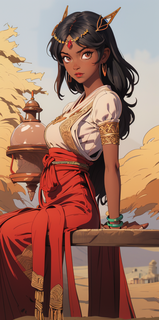
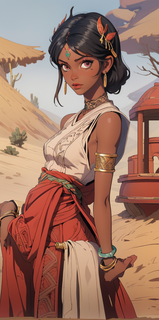
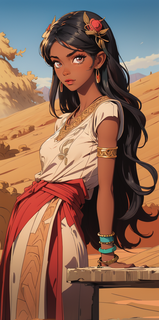

In [ ]:
import json
import os
import zipfile
import base64
import ipywidgets as widgets
from IPython.display import display
import mediapy
from PIL import Image
import glob
import uuid
from google.colab import output, files
from IPython.display import HTML
from google.colab import output
output.disable_custom_widget_manager()
output.no_vertical_scroll()

def extract_metadata(image):
    try:
        metadata = {}
        if 'metadata' in image.info:
            metadata = json.loads(image.info['metadata'])
        elif 'prompt' in image.info:
            metadata = json.loads(image.info['prompt'])
        elif 'Comment' in image.info:
            metadata = json.loads(image.info['Comment'])
            metadata['model'] = 'NovelAI'
        elif 'parameters' in image.info:
            if image.info['parameters'].startswith('{'):
                parameters_data = json.loads(image.info['parameters'])
                if 'sui_image_params' in parameters_data:
                    sui_image_params = parameters_data['sui_image_params']
                    metadata.update(sui_image_params)
                else:
                    metadata = parameters_data
            elif "\n" in image.info['parameters']:
                lines = image.info['parameters'].split('\n')
                prompt = lines[0].strip()
                negative_prompt = lines[1].strip().replace('Negative prompt:', '').strip()
                metadata['prompt'] = prompt
                metadata['negative_prompt'] = negative_prompt

                for line in lines[2:]:
                    line = line.strip()
                    if line.startswith('Steps:'):
                        steps_info = line.split(':', 1)[1].strip().split(',')
                        for info in steps_info:
                            info = info.strip()
                            if ':' in info:
                                key, value = info.split(':', 1)
                                metadata[key.strip()] = value.strip()
            else:
                metadata = image.info['parameters']
        else:
            return "No supported metadata found in the image."

        return metadata
    except Exception as e:
        return "Error extracting metadata"

class InvokeButton(object):
    def __init__(self, title, callback):
        self._title = title
        self._callback = callback

    def _repr_html_(self):
        callback_id = 'button-' + str(uuid.uuid4())
        output.register_callback(callback_id, self._callback)

        template = """<button id="{callback_id}">{title}</button>
            <script>
              document.querySelector("#{callback_id}").onclick = (e) => {{
                google.colab.kernel.invokeFunction('{callback_id}', [], {{}})
                e.preventDefault();
              }};
            </script>"""
        html = template.format(title=self._title, callback_id=callback_id)
        return html

def download_archive(path):
    files.download(path)

#@title Simple Gallery Explorer and PNG info { form-width: "20%", display-mode: "form" }

page = 1 # @param {type:"integer"}
page = page if page else 1
number_of_images_per_page = 10 # @param {type:"integer"}

columns = 2 # @param {type:"integer"}
maximum_thumbnail_image_size = 320 # @param {type:"integer"}

folder_where_the_images_are_located = "/content/images/" # @param {type:"string"}
#@markdown It also works with individual images, e.g., `/content/myimage.png`

if os.path.isfile(folder_where_the_images_are_located):
    all_files = [folder_where_the_images_are_located]
elif os.path.isdir(folder_where_the_images_are_located):
    # all_files = glob.glob(os.path.join(folder_where_the_images_are_located, '*.*'))
    all_files = glob.glob(os.path.join(folder_where_the_images_are_located, '**', '*.*'), recursive=True)
else:
    raise ValueError(f"{folder_where_the_images_are_located} does not exist.")

img_extensions = ['.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff', '.webp']
all_images = [
    file for file in all_files if os.path.splitext(file)[1].lower() in img_extensions
]
# all_images.sort()
all_images = sorted(all_images, key=os.path.basename)

images_gallery = []
for i in range((number_of_images_per_page * (page-1)), min((number_of_images_per_page * page), len(all_images))):
    img_gallery = Image.open(all_images[i])
    images_gallery.append([img_gallery, all_images[i]])

# Define your images dictionary with HTML styling for the text
images = {
    f'''
    <div style="border: 1px solid #ccc; border-radius: 8px; padding: 15px; margin: 15px; background-color: #f4ecd8; box-shadow: 0 4px 8px rgba(0,0,0,0.1); max-width: 320px;">
        <span style="font-weight: bold; color: #333; font-size: 12px; font-family: Arial, sans-serif;">{os.path.basename(path_file)}</span>
        <div style="margin-top: 10px;">
            {InvokeButton('Download', lambda path_file=path_file: download_archive(path_file))._repr_html_()}
        </div>
        <details style="margin-top: 10px;">
            <summary style="font-size: 11px; font-weight: bold; cursor: pointer; color: #cc5500;">Parameters 👇</summary>
            <p style="font-size: 10px; color: #666;">{extract_metadata(img_gallery)}</p>
        </details>

    </div>
    ''': img_gallery
    for img_gallery, path_file in images_gallery
}

mediapy.show_images(images, border=True, columns=columns, height=maximum_thumbnail_image_size)

def create_zip_file(image_paths, zip_path="images.zip"):
    with zipfile.ZipFile(zip_path, 'w') as zipf:
        for image_path in image_paths:
            zipf.write(image_path, os.path.basename(image_path))
    return zip_path

def zip_download_archive():
    print("Creating the ZIP file...")
    image_files = [path_file for img_gallery, path_file in images_gallery]

    base_name_start = os.path.splitext(os.path.basename(image_files[0]))[0]
    base_name_end = os.path.splitext(os.path.basename(image_files[-1]))[0]

    zip_name = f"gallery_from_{base_name_start}_to_{base_name_end}.zip"
    initial_zip_path = create_zip_file(image_files, zip_name)

    print("Downloading...")
    download_archive(initial_zip_path)

if images_gallery:
    display(HTML(InvokeButton('Download ZIP 📦', zip_download_archive)._repr_html_()))


In [ ]:
#@title Codeformer: Upscale and face restoration { form-width: "20%", display-mode: "form" }
from IPython.utils import capture
import os
import shutil
count_runs = 0

%cd /content
directory_codeformer = '/content/CodeFormer/'
with capture.capture_output() as cap:
  if not os.path.exists(directory_codeformer):
      os.makedirs(directory_codeformer)

      # Setup
      # Clone CodeFormer and enter the CodeFormer folder
      %cd /content
      !git clone https://github.com/sczhou/CodeFormer.git
      %cd CodeFormer


      # Set up the environment
      # Install python dependencies
      !pip install -q -r requirements.txt
      !pip -q install ffmpeg
      # Install basicsr
      !python basicsr/setup.py develop

      # Download the pre-trained model
      !python scripts/download_pretrained_models.py facelib
      !python scripts/download_pretrained_models.py CodeFormer
  del cap
# Visualization function
import cv2
import matplotlib.pyplot as plt
def display_codeformer(img1, img2):
  fig = plt.figure(figsize=(25, 10))
  ax1 = fig.add_subplot(1, 2, 1)
  plt.title('Input', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 2, 2)
  plt.title('CodeFormer', fontsize=16)
  ax2.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2)
def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# Copy imgs
Select_an_image = "" # @param {type:"string"}

# PROCESS AD
if os.path.exists(Select_an_image.strip()):
    image_list = [Select_an_image.replace('/content/', '').strip()]

destination_directory = '/content/CodeFormer/inputs/user_upload'
!rm -rf /content/CodeFormer/inputs/user_upload/*
os.makedirs(destination_directory, exist_ok=True)
for image_path in image_list:
    image_filename = os.path.basename('/content/'+image_path)
    destination_path = os.path.join(destination_directory, image_filename)
    try:
        shutil.copyfile('/content/'+image_path, destination_path)
        print(f"Image '{image_filename}' has been copied to '{destination_path}'")
    except Exception as e:
        print(f"Failed to copy '{image_filename}' to '{destination_path}': {e}")

#@markdown `CODEFORMER_FIDELITY`: Balance the quality (lower number) and fidelity (higher number)<br>
# you can add '--bg_upsampler realesrgan' to enhance the background
CODEFORMER_FIDELITY = 0.7 #@param {type:"slider", min:0, max:1, step:0.01}
#@markdown `BACKGROUND_ENHANCE`: Enhance background image with Real-ESRGAN<br>
BACKGROUND_ENHANCE = False #@param {type:"boolean"}
#@markdown `FACE_UPSAMPLE`: Upsample restored faces for high-resolution AI-created images<br>
FACE_UPSAMPLE = True #@param {type:"boolean"}
#markdown `HAS_ALIGNED`: Input are cropped and aligned faces<br>
HAS_ALIGNED =  False
#@markdown `UPSCALE`: The final upsampling scale of the image. Default: 2<br>
UPSCALE = 1 #@param {type:"slider", min:1, max:8, step:1}
#markdown `DETECTION_MODEL`: Face detector. Default: retinaface_resnet50<br>
DETECTION_MODEL = "retinaface_resnet50"
#markdown `DRAW_BOX`: Draw the bounding box for the detected faces.
DRAW_BOX = False

BACKGROUND_ENHANCE = '--bg_upsampler realesrgan' if BACKGROUND_ENHANCE else ''
FACE_UPSAMPLE = '--face_upsample' if FACE_UPSAMPLE else ''
HAS_ALIGNED = '--has_aligned' if HAS_ALIGNED else ''
DRAW_BOX = '--draw_box' if DRAW_BOX else ''
%cd CodeFormer
!python inference_codeformer.py -w $CODEFORMER_FIDELITY --input_path {destination_directory} {BACKGROUND_ENHANCE} {FACE_UPSAMPLE} {HAS_ALIGNED} --upscale {UPSCALE} --detection_model {DETECTION_MODEL} {DRAW_BOX}


import os
import glob

input_folder = 'inputs/user_upload'
result_folder = f'results/user_upload_{CODEFORMER_FIDELITY}/final_results'
input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
for input_path in input_list:
  img_input = imread(input_path)
  basename = os.path.splitext(os.path.basename(input_path))[0]
  output_path = os.path.join(result_folder, basename+'.png')
  img_output = imread(output_path)
  display_codeformer(img_input, img_output)

%cd /content

Upscale results in /content/CodeFormer/results


In [ ]:
#@title Download Images
import os
from google.colab import files
!rm /content/results.zip
!ls /content/images
print('Download results')
os.system(f'zip -r results.zip /content/images')
try:
  files.download("results.zip")
except:
  print("Error")

In [ ]:
#@title Download Upscale results
import os
from google.colab import files
import shutil
%cd /content/CodeFormer
!ls results
print('Download results')
os.system(f'zip -r results.zip results/user_upload_{CODEFORMER_FIDELITY}/final_results')
try:
  files.download("results.zip")
except:
  files.download(f'/content/CodeFormer/results/{filename[:-4]}_{CODEFORMER_FIDELITY}/{filename}')
%cd /content

# Extras for advanced users

In [ ]:
# You can also use this cell to simply reload the model in case you need to.
del model

In [ ]:
# If the generate button is disabled
generate.disabled = False

In [ ]:
# If you encounter a problem with "Out Of Memory," you can click on this cell and rerun cells 2 and 3.
import os
os.kill(os.getpid(), 9)

In [ ]:
# @title Alternative generation
# @markdown Sometimes the GUI gets stuck when multiple operations are run. Once the GUI is loaded, you can use this cell to generate images here as an alternative.

count_runs = 0
def generate_img_beta():
    global model

    print("Loading model...")

    # First load
    try:
        model
    except:
        model = Model_Diffusers(base_model_id=select_model.value, task_name=select_task.value, vae_model=vae_model_dropdown.value, type_model_precision=model_precision.value, retain_task_model_in_cache=retain_task_model_in_cache.value)

    try:
        model.load_pipe(select_model.value, task_name=select_task.value, vae_model=vae_model_dropdown.value, type_model_precision=model_precision.value, retain_task_model_in_cache=retain_task_model_in_cache.value)
    except Exception as error:
        check_error(error)

    display_imgs.clear_output()

    global destination_path_cn_img, mask_control, image_list, count_runs, save_and_load_config

    image_control_base = None
    if select_task.value != control_model_list[13]:
        try:
            image_control_base = destination_path_cn_img
        except:
            print("No control image found: To use this function, you have to upload an image in the cell 'Upload an image 👈‍‍ 🖼️🖼️🖼️' first 👇")
            generate.disabled = False
            return

    mask_control_base = ""
    if select_task.value == control_model_list[12]:
        if os.path.exists(mask_inpaint_gui.value):
            mask_control_base = mask_inpaint_gui.value
        else:
            try:
                mask_control_base = mask_control
            except:
                print("No mask image found: Specify a path in the GUI or create one using cell 'Upload an image 👈‍‍ 🖼️🖼️🖼️'")
                generate.disabled = False
                return

    if upscaler_model_path_gui.value in [None, "Lanczos", "Nearest"] + list(LATENT_UPSCALERS):
        upscaler_model = upscaler_model_path_gui.value
    else:
        directory_upscalers = 'upscalers'
        os.makedirs(directory_upscalers, exist_ok=True)

        url_upscaler = upscaler_dict_gui[upscaler_model_path_gui.value]

        if not os.path.exists(f"./upscalers/{url_upscaler.split('/')[-1]}"):
            download_things(directory_upscalers, url_upscaler, hf_token)

        upscaler_model = f"./upscalers/{url_upscaler.split('/')[-1]}"

    if active_ti.value == True and model.class_name == "StableDiffusionXLPipeline":
        print("No Textual inversion for SDXL")

    logging.getLogger("ultralytics").setLevel(logging.INFO if adetailer_verbose.value else logging.ERROR)

    count_runs += 1
    if count_runs%11 == 0 and count_runs != 0:
        print("🖱️ Keep in mind to occasionally make use of other cells, such as 'Codeformer', to prevent any inconvenience from disconnection due to inactivity.")

    params_ip_img = []
    params_ip_msk = []
    params_ip_model = []
    params_ip_mode = []
    params_ip_scale = []

    all_adapters = [
        (ip_adapter_image00, ip_adapter_mask00, ip_adapter_model00, ip_adapter_mode00, ip_adapter_scale00),
        (ip_adapter_image01, ip_adapter_mask01, ip_adapter_model01, ip_adapter_mode01, ip_adapter_scale01),
        (ip_adapter_image02, ip_adapter_mask02, ip_adapter_model02, ip_adapter_mode02, ip_adapter_scale02),
    ]

    for imgip, mskip, modelip, modeip, scaleip in all_adapters:
        if imgip.value:
            params_ip_img.append(imgip.value)
            params_ip_msk.append(mskip.value)
            params_ip_model.append(modelip.value)
            params_ip_mode.append(modeip.value)
            params_ip_scale.append(scaleip.value)

    adetailer_params_A = {
        "face_detector_ad" : face_detector_ad_A.value,
        "person_detector_ad" : person_detector_ad_A.value,
        "hand_detector_ad" : hand_detector_ad_A.value,
        "prompt": prompt_ad_A.value,
        "negative_prompt" : negative_prompt_ad_A.value,
        "strength" : strength_ad_A.value,
        "mask_dilation" : mask_dilation_A.value,
        "mask_blur" : mask_blur_A.value,
        "mask_padding" : mask_padding_A.value,
        "inpaint_only" : adetailer_inpaint_only.value,
        "sampler" : adetailer_sampler.value,
    }

    adetailer_params_B = {
        "face_detector_ad" : face_detector_ad_B.value,
        "person_detector_ad" : person_detector_ad_B.value,
        "hand_detector_ad" : hand_detector_ad_B.value,
        "prompt": prompt_ad_B.value,
        "negative_prompt" : negative_prompt_ad_B.value,
        "strength" : strength_ad_B.value,
        "mask_dilation" : mask_dilation_B.value,
        "mask_blur" : mask_blur_B.value,
        "mask_padding" : mask_padding_B.value,
    }
    pipe_params = {
        "prompt": prompt.value,
        "negative_prompt": neg_prompt.value,
        "img_height": img_height.value,
        "img_width": img_width.value,
        "num_images": num_images.value,
        "num_steps": steps.value,
        "guidance_scale": CFG.value,
        "clip_skip": select_clip_skip.value,
        "seed": random_seed.value,
        "image": image_control_base,
        "preprocessor_name": base_preprocessor.value,
        "preprocess_resolution": preprocess_resolution_global.value,
        "image_resolution": image_resolution_global.value,
        "style_prompt": style_names_multi_selection.value,
        "style_json_file" : "",
        "pag_scale": pag_scale.value,
        "image_mask": mask_control_base,  # only for Inpaint
        "strength": strength_gui.value,
        "low_threshold": canny_low.value,
        "high_threshold": canny_high.value,
        "value_threshold": mlsd_value.value,
        "distance_threshold": mlsd_distance.value,
        "recolor_gamma_correction": gamma_correction.value,
        "lora_A": select_lora1.value,
        "lora_scale_A": lora_weights_scale1.value,
        "lora_B": select_lora2.value,
        "lora_scale_B": lora_weights_scale2.value,
        "lora_C": select_lora3.value,
        "lora_scale_C": lora_weights_scale3.value,
        "lora_D": select_lora4.value,
        "lora_scale_D": lora_weights_scale4.value,
        "lora_E": select_lora5.value,
        "lora_scale_E": lora_weights_scale5.value,
        "textual_inversion": embed_list if active_ti.value and model.class_name != "StableDiffusionXLPipeline" else [],
        "syntax_weights" : weights_prompt.value, #"Classic" , #"convert_weights_prompt": weights_prompt.value,
        "sampler": select_sampler.value,
        "xformers_memory_efficient_attention": xformers_memory_efficient_attention.value,
        "gui_active": True,
        "loop_generation": loop_generator.value,
        "controlnet_conditioning_scale" : controlnet_output_scaling_in_unet.value,
        "control_guidance_start" : controlnet_start_threshold.value,
        "control_guidance_end" : controlnet_stop_threshold.value,
        "generator_in_cpu" : init_generator_in_cpu.value,
        "FreeU" : freeu_check.value,
        "adetailer_A" : adetailer_active_A.value,
        "adetailer_A_params" : adetailer_params_A,
        "adetailer_B" : adetailer_active_B.value,
        "adetailer_B_params" : adetailer_params_B,
        "leave_progress_bar" : True,
        "disable_progress_bar" : disable_progress_bar_check.value,
        "image_previews" : False,
        "display_images" : display_images.value,
        "save_generated_images" : save_generated_images.value,
        "image_storage_location" : image_directory.value,
        "retain_compel_previous_load" : retain_compel_previous_load.value,
        "retain_detailfix_model_previous_load": retain_detailfix_model_previous_load.value,
        "retain_hires_model_previous_load": retain_hires_model_previous_load.value,
        "t2i_adapter_preprocessor" : t2i_adapter_preprocessor_check.value,
        "t2i_adapter_conditioning_scale" : adapter_conditioning_scale_scale.value,
        "t2i_adapter_conditioning_factor" : adapter_conditioning_factor_fraction.value,
        "upscaler_model_path" : upscaler_model,
        "upscaler_increases_size" : upscaler_increases_size.value,
        "esrgan_tile" : esrgan_tile.value,
        "esrgan_tile_overlap" : esrgan_tile_overlap.value,
        "hires_steps" : hires_steps.value,
        "hires_denoising_strength" : hires_denoising_strength.value,
        "hires_prompt" : hires_prompt.value,
        "hires_negative_prompt" : hires_negative_prompt.value,
        "hires_sampler" : hires_sampler.value,
        "hires_before_adetailer" : hires_before_adetailer.value,
        "hires_after_adetailer" : hires_after_adetailer.value,
        "ip_adapter_image": params_ip_img,
        "ip_adapter_mask": params_ip_msk,
        "ip_adapter_model": params_ip_model,
        "ip_adapter_mode": params_ip_mode,
        "ip_adapter_scale": params_ip_scale,
    }

    if show_params.value:
        print(pipe_params)

    try:
        images, image_list = model(**pipe_params)
    except Exception as error:
        check_error(error)

    generate.disabled = False

    if save_and_load_config:
        # save config
        file_path = 'config_load.json'

        pipe_params["select_model"] = select_model.label
        pipe_params["task_name"] = select_task.label
        pipe_params["vae_model"] = vae_model_dropdown.label
        pipe_params["type_model_precision"] = model_precision.label
        pipe_params["upscaler_model_path"] = upscaler_model_path_gui.label
        pipe_params["prompt"] = make_string_fancy(pipe_params["prompt"])
        pipe_params["negative_prompt"] = make_string_fancy(pipe_params["negative_prompt"])
        pipe_params["textual_inversion"] = active_ti.value
        pipe_params.pop("adetailer_A_params", None)
        pipe_params.pop("adetailer_B_params", None)
        pipe_params["hires_prompt"] = make_string_fancy(pipe_params["hires_prompt"])
        pipe_params["hires_negative_prompt"] = make_string_fancy(pipe_params["hires_negative_prompt"])
        with open(file_path, 'w') as json_file:
            json.dump(pipe_params, json_file, indent=2)

    torch.cuda.empty_cache()
    gc.collect()

    return

generate_img_beta()

In [ ]:
import os
from huggingface_hub import HfApi
import tempfile
from typing import Optional, Union
import random
import string
count_runs = 0

#@title Submit the images to your Hugging Face repository (Need an account on Hugging Face) { form-width: "20%", display-mode: "form" }
#@markdown Basically, this allows you to use a repository on Hugging Face to store whatever you want. In this case, we want to use the repository to store our generated images

#@markdown ---
#@markdown **Specify the folder of the images you will upload and the destination folder in the repository**
folder_in_notebook = "images" # @param {type:"string"}
folder_in_repo = "images_24_11_23" # @param {type:"string"}
#@markdown ---
#@markdown **Select the destination repository from your account; if it doesn't exist, it will be created. Example: `your_username/random_name_repo`**
repo_id = "" # @param {type:"string"}
private_repo = True # @param {type:"boolean"}
#@markdown **To be able to use your repository, you need a token with write permissions. You can get it here: https://huggingface.co/settings/tokens.**
token = "" # @param {type:"string"}

api = HfApi()
api.create_repo(
    repo_id = repo_id,
    repo_type = "dataset",
    private = private_repo,
    exist_ok = True,
    token = token,
)

api.upload_folder(
    folder_path=folder_in_notebook,
    path_in_repo=folder_in_repo,
    repo_id=repo_id,
    token= token,
    repo_type="dataset",
    #ignore_patterns="**/logs/*.txt",
)

print(f"https://huggingface.co/datasets/{repo_id}/tree/main/{folder_in_repo}")

In [ ]:
# @title Select a style file for the loaded model
import os

style_file = "sdxl_styles" # @param ["sdxl_styles", "sdxl_styles_sai", "sdxl_styles_twri"] {type:"string"}

styles_dict_p = {
    "sdxl_styles" : "https://raw.githubusercontent.com/ahgsql/StyleSelectorXL/main/sdxl_styles.json",
    "sdxl_styles_sai" : "https://raw.githubusercontent.com/twri/sdxl_prompt_styler/main/sdxl_styles_sai.json",
    "sdxl_styles_twri" : "https://raw.githubusercontent.com/twri/sdxl_prompt_styler/main/sdxl_styles_twri.json",
}

url = styles_dict_p[style_file]
!wget {url} -q

model.load_style_file(os.path.basename(url))
style_names_multi_selection.options = model.STYLE_NAMES
print("New styles set in the GUI")

In [ ]:
# @markdown #### or submit and load a style file in the model (json format) [PromptStylers](https://github.com/wolfden/ComfyUi_PromptStylers), [sdxl_prompt_styler](https://github.com/ali1234/sdxl_prompt_styler/tree/main)
from google.colab import files

uploaded = files.upload()
file_names = list(uploaded.keys())

if file_names[0].endswith('.json'):
    model.load_style_file(file_names[0])
    style_names_multi_selection.options = model.STYLE_NAMES
    print("New styles set in the GUI")
else:
    print("Error: Need a json file")

In [ ]:
from stablepy.diffusers_vanilla.utils import save_pil_image_with_metadata
from stablepy import UpscalerESRGAN
import os
from PIL import Image
count_runs = 0

upscaler_dict = {
    "RealESRGAN_x4plus" : "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth",
    "RealESRNet_x4plus" : "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.1/RealESRNet_x4plus.pth",
    "RealESRGAN_x4plus_anime_6B": "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.2.4/RealESRGAN_x4plus_anime_6B.pth",
    "RealESRGAN_x2plus": "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.1/RealESRGAN_x2plus.pth",
    "realesr-animevideov3": "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.5.0/realesr-animevideov3.pth",
    "realesr-general-x4v3": "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.5.0/realesr-general-x4v3.pth",
    "realesr-general-wdn-x4v3" : "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.5.0/realesr-general-wdn-x4v3.pth",
    "4x-UltraSharp" : "https://huggingface.co/Shandypur/ESRGAN-4x-UltraSharp/resolve/main/4x-UltraSharp.pth",
    "4x_foolhardy_Remacri" : "https://huggingface.co/FacehugmanIII/4x_foolhardy_Remacri/resolve/main/4x_foolhardy_Remacri.pth",
    "Remacri4xExtraSmoother" : "https://huggingface.co/hollowstrawberry/upscalers-backup/resolve/main/ESRGAN/Remacri%204x%20ExtraSmoother.pth",
    "AnimeSharp4x" : "https://huggingface.co/hollowstrawberry/upscalers-backup/resolve/main/ESRGAN/AnimeSharp%204x.pth",
    "lollypop" : "https://huggingface.co/hollowstrawberry/upscalers-backup/resolve/main/ESRGAN/lollypop.pth",
    "RealisticRescaler4x" : "https://huggingface.co/hollowstrawberry/upscalers-backup/resolve/main/ESRGAN/RealisticRescaler%204x.pth",
    "NickelbackFS4x" : "https://huggingface.co/hollowstrawberry/upscalers-backup/resolve/main/ESRGAN/NickelbackFS%204x.pth"
}

#@markdown # Alternative Upscaler Tool
#@markdown You can leave `Select_an_image` blank to process the last generated images.
Select_an_image = "" # @param {type:"string"}
MODEL_UPSCALER = "RealESRGAN_x4plus_anime_6B" #@param ["RealESRGAN_x4plus", "RealESRNet_x4plus", "RealESRGAN_x2plus", "RealESRGAN_x4plus_anime_6B", "realesr-animevideov3", "realesr-general-x4v3", "realesr-general-wdn-x4v3", "4x-UltraSharp", "4x_foolhardy_Remacri", "Remacri4xExtraSmoother", "AnimeSharp4x", "lollypop", "RealisticRescaler4x", "NickelbackFS4x"]
Scale_of_the_image_x = 1.5 #@param {type:"slider", min:1, max:4, step:0.5}
show_result = True #@param {type: "boolean"}

directory_upscalers = 'upscalers'
os.makedirs(directory_upscalers, exist_ok=True)

url_upscaler = upscaler_dict[MODEL_UPSCALER]

if not os.path.exists(f"./upscalers/{url_upscaler.split('/')[-1]}"):
    download_things(directory_upscalers, url_upscaler, hf_token)

scaler_beta = UpscalerESRGAN()

if os.path.exists(Select_an_image.strip()):
    image_list = [Select_an_image.replace('/content/', '').strip()]

for img_base in image_list:
    img_pil = Image.open(img_base)
    img_up = scaler_beta.upscale(img_pil, Scale_of_the_image_x , f"./upscalers/{url_upscaler.split('/')[-1]}")

    if show_result:
        display(img_up)

    image_path = save_pil_image_with_metadata(img_up, f'{os.getcwd()}/up_images', metadata_list=None)
    print(image_path)

In [ ]:
from PIL import Image
import os, torch, gc
count_runs = 0
from stablepy.diffusers_vanilla.adetailer import ad_model_process
from stablepy.diffusers_vanilla.utils import save_pil_image_with_metadata
from stablepy.diffusers_vanilla.extra_model_loaders import custom_task_model_loader

torch.cuda.empty_cache()
gc.collect()

detailfix_pipe = custom_task_model_loader(
    pipe=model.pipe,
    model_category="detailfix", # inpaint_only = True
    task_name=select_task.label,
    torch_dtype=model_precision.value
)
detailfix_pipe.to("cuda" if torch.cuda.is_available() else "cpu")
# same scheduler as base pipe

# OPTIONS #
# @markdown # Adetailer (inpaint only)
# @markdown This will use the parameters and the loaded model of the GUI.
Select_an_image = "" # @param {type:"string"}
prompt_ad = "masterpiece, best quality, extremely detailed wallpaper" # @param {type:"string"}
negative_prompt_ad = "worst quality, normal quality, low quality, low res, blurry, text, watermark, logo, banner, extra digits, cropped, jpeg artifacts, signature, username, error, sketch ,duplicate, ugly, monochrome, horror, geometry, mutation, disgusting" # @param {type:"string"}
strength_ad = 0.4 # @param {type:"number"}
face_detector_ad = True # @param {type:"boolean"}
person_detector_ad = True # @param {type:"boolean"}
hand_detector_ad = False # @param {type:"boolean"}
mask_dilation = 4 # @param {type:"integer"}
mask_blur = 4 # @param {type:"integer"}
mask_padding = 32 # @param {type:"integer"}

detailfix_params__ = {
    "prompt": prompt_ad,
    "negative_prompt" : negative_prompt_ad,
    "strength" : strength_ad,
    "num_inference_steps": steps.value,
    "guidance_scale" : CFG.value,
}
adetailer_params__ = {
    "face_detector_ad" : face_detector_ad,
    "person_detector_ad" : person_detector_ad,
    "hand_detector_ad" : hand_detector_ad,
    #"inpaint_only" : True,
    # "image_list_task" : None,
    "mask_dilation" : mask_dilation,
    "mask_blur" : mask_blur,
    "mask_padding" : mask_padding,
}

# PROCESS AD
if os.path.exists(Select_an_image):
    image_list = [Select_an_image]

image_pil_list = []
for path in image_list:
    if os.path.exists(path):
        # Open the image using PIL and convert it to PIL.Image.Image
        with Image.open(path) as img:
            image_ad = img.convert("RGB")
            image_pil_list.append(image_ad)

ad_pil_list = ad_model_process(
    pipe_params_df=detailfix_params__,
    detailfix_pipe=detailfix_pipe,
    image_list_task=image_pil_list,
    **adetailer_params__,
)

for img_ad in ad_pil_list:
    display(img_ad)
    image_path = save_pil_image_with_metadata(img_ad, f'{os.getcwd()}/images', metadata_list=None)
    print(image_path)

del detailfix_pipe
torch.cuda.empty_cache()
gc.collect()
print("")

In [ ]:
# @markdown CONVERT SAFETENSORS TO DIFFUSERS
path_safetensor_model = "" # @param {type:"string"}
path_diffusers_model = "./converted_model/" # @param {type:"string"}

from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_single_file(path_safetensor_model).to("cuda")
pipe.save_pretrained(path_diffusers_model) # model path inpaint is ./adetailer_model/
del pipe
torch.cuda.empty_cache()
gc.collect()

In [ ]:
from stablepy import logger
Verbosity_Level = "INFO" # @param ["DEBUG", "INFO", "WARNING", "ERROR", "CRITICAL"]
import logging, warnings, diffusers

logging_level_mapping = {
    'DEBUG': logging.DEBUG,
    'INFO': logging.INFO,
    'WARNING': logging.WARNING,
    'ERROR': logging.ERROR,
    'CRITICAL': logging.CRITICAL
}

if Verbosity_Level != "DEBUG":
    logging.getLogger("diffusers").setLevel(logging.ERROR)
    diffusers.utils.logging.set_verbosity(40)
    #warnings.resetwarnings()
    warnings.filterwarnings(action="ignore", category=FutureWarning, module="diffusers")
    warnings.filterwarnings(action="ignore", category=UserWarning, module="diffusers")
else:
    logging.getLogger("diffusers").setLevel(logging.INFO)
    diffusers.utils.logging.set_verbosity(30)
    warnings.filterwarnings(action="default", category=FutureWarning, module="diffusers")
    warnings.filterwarnings(action="default", category=UserWarning, module="diffusers")

logger.setLevel(logging_level_mapping.get(Verbosity_Level, logging.NOTSET))